# Домашняя работа 5

Поработаем с датасетом о [пользователях кредитных карт](https://www.kaggle.com/arjunbhasin2013/ccdata). 

Мы хотим кластеризовать пользователей на категории для того, чтобы по-разному настраивать рекламу на них.


## Easy

Выдвинуть гипотезу по каким признакам нужно кластеризовать пользователей. Провести кластеризацию одним любым методом, проанализировать "на глаз" насколько хорошо получилось, можно ли как-то проинтерпретировать кластеры?

In [1]:
# !pip install umap

In [2]:
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from umap.umap_ import UMAP
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [3]:
dir = "../data"

In [4]:
df = pd.read_csv(f'{dir}/CC GENERAL.csv')
df.head(3)

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                         0.0                          0.083333   
1                         0.0                          0.000000   
2                         1.0                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00                 0              2        1000.0   
1                    0.25                 4              0        7000.0   
2                    0.00                 0             12        7500.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12

In [5]:
print(df.shape, df.columns.to_list(), sep="\n")

(8950, 18)
['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


выдвигаю гипотезу: надо тренироваться только на численных признаках без пропусков:)

In [6]:
df_numeric = df.select_dtypes(include='number')
df_numeric.dropna(inplace=True, axis=1)
df_numeric.shape

(8950, 15)

In [7]:
tsne = TSNE()
tsne_data = tsne.fit_transform(df_numeric)

In [8]:
def plot(data, labels=None):
    plt.figure(figsize=(10, 10))
    if labels is not None:
        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels)
    else:
         sns.scatterplot(x=data[:, 0], y=data[:, 1])
    plt.plot()

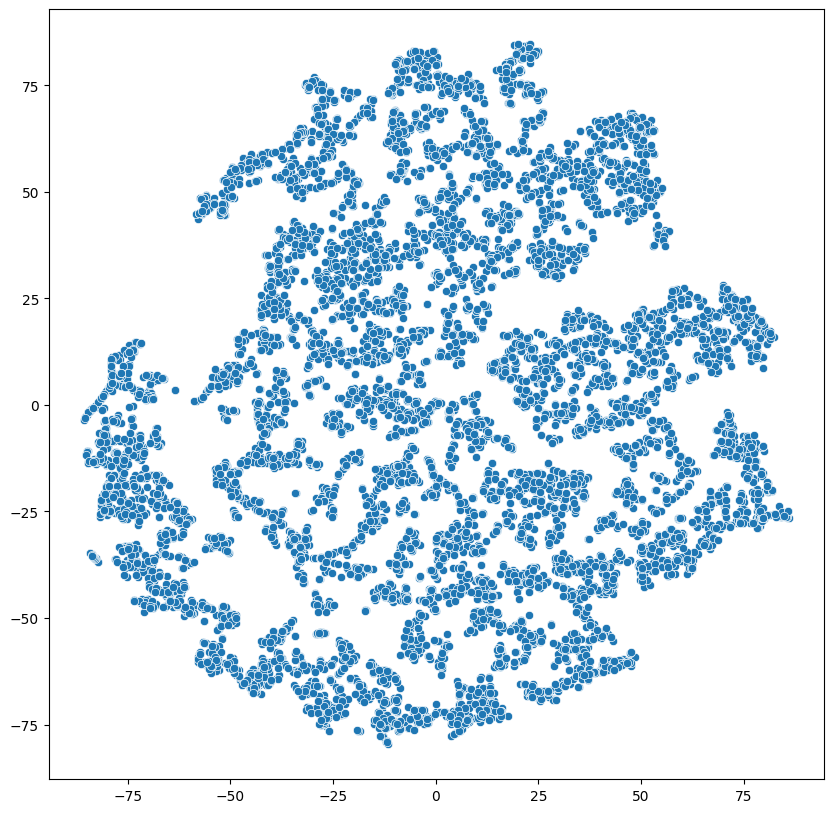

In [9]:
plot(tsne_data)

In [10]:
umap = UMAP(random_state=42)
embedding = umap.fit_transform(df_numeric)

C:\Users\bentodan\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


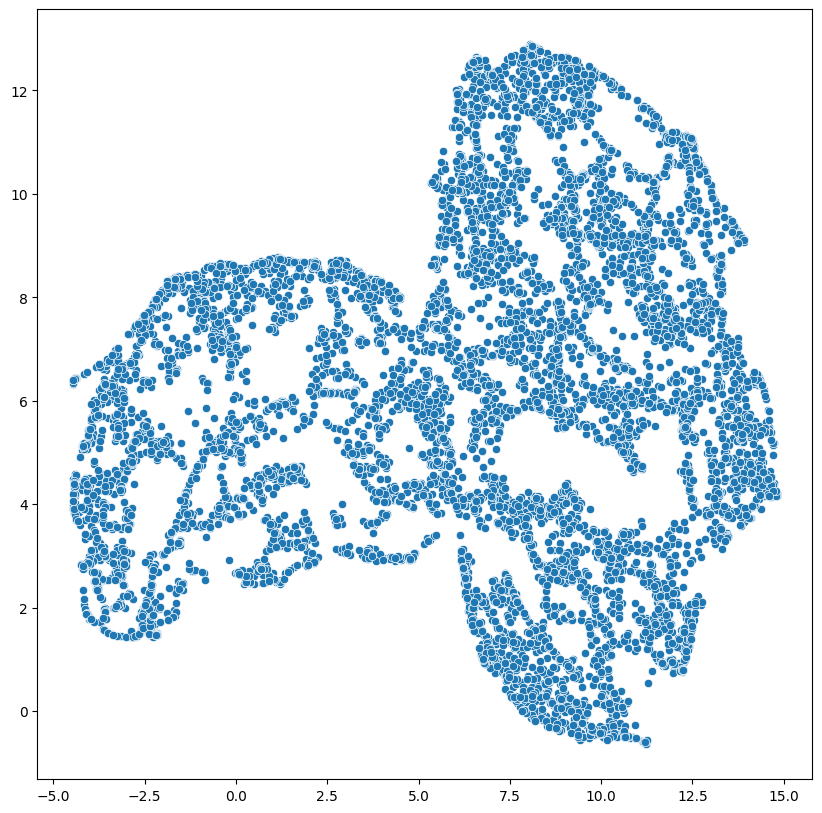

In [11]:
plot(embedding)

In [12]:
dbscan = DBSCAN(eps=10, min_samples=4, metric='minkowski', p=2).fit(df_numeric)

In [13]:
pd.Series(dbscan.labels_).unique()

array([-1,  0,  8,  7,  4,  1,  2,  5,  3,  6], dtype=int64)

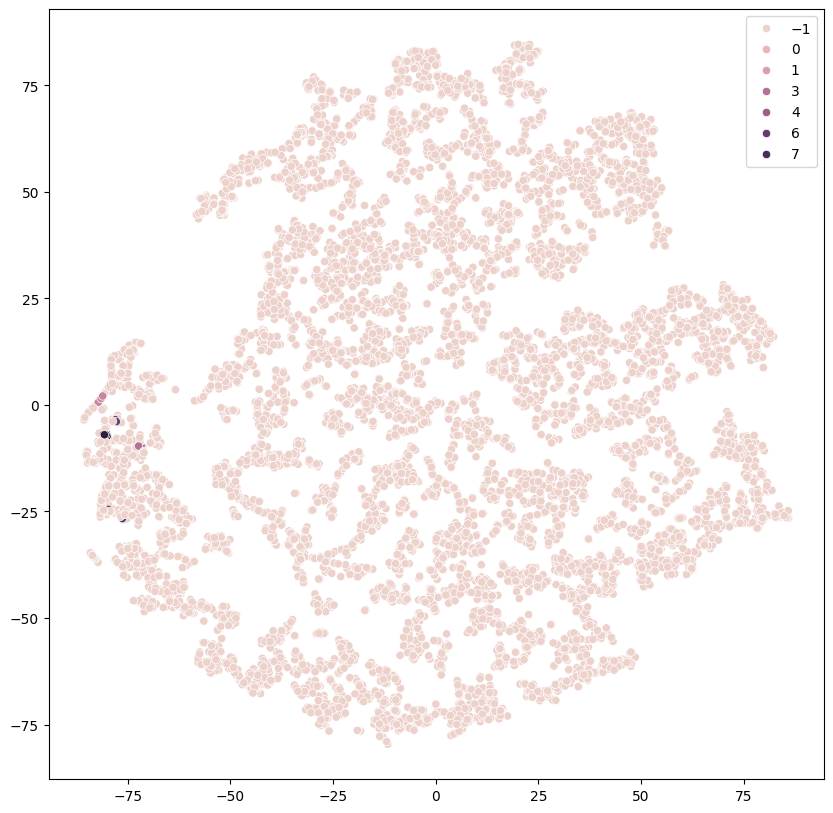

In [14]:
plot(tsne_data, dbscan.labels_)

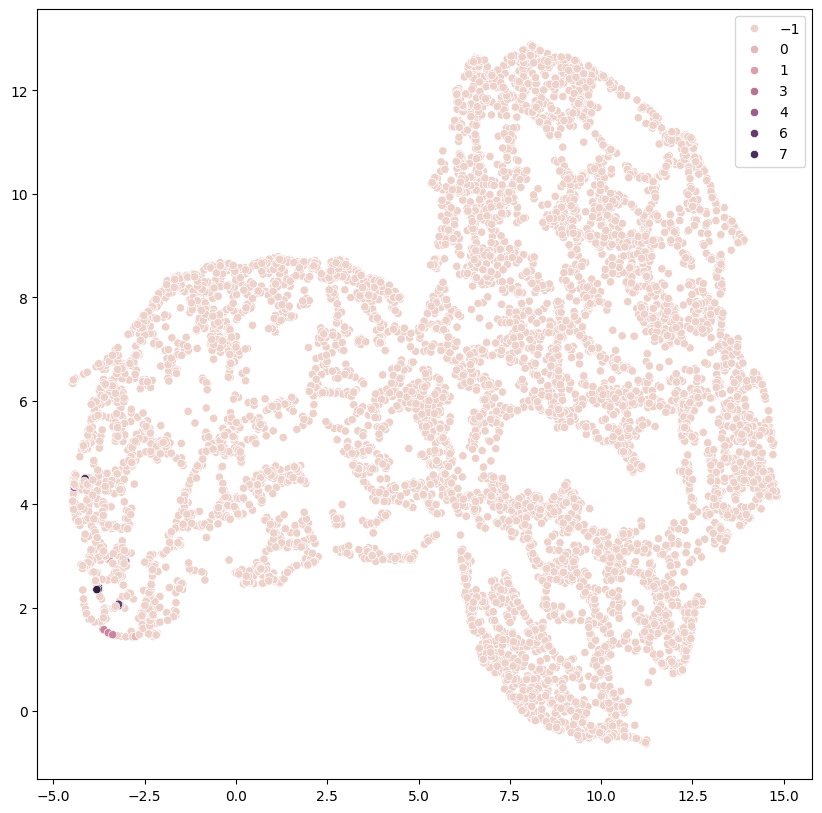

In [15]:
plot(embedding, dbscan.labels_)

как видим, получается плохо, когда я брал меньшее eps (минимально расстояние до потенциальных соседей), кластер вообще был один. По сути, он и сейчас определяется как один 


## Normal

Провести кластеризацию несколькими методами. Объяснить какой результат лучше и почему. Проинтерпретировать кластеры в лучшем разбиении.

In [16]:
kmeans = KMeans(n_clusters=3, max_iter=500, tol=1e-3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_numeric)

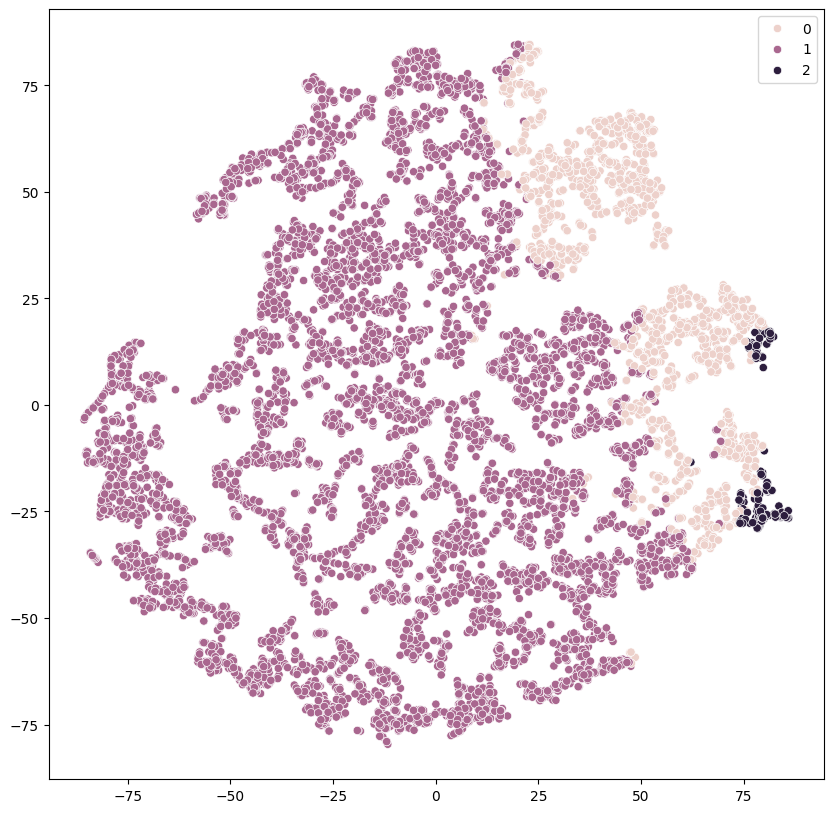

In [17]:
plot(tsne_data, kmeans_labels) # кажется, с таким подходом кластеров все же два

In [18]:
kmeans = KMeans(n_clusters=2, max_iter=500, tol=1e-3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_numeric)

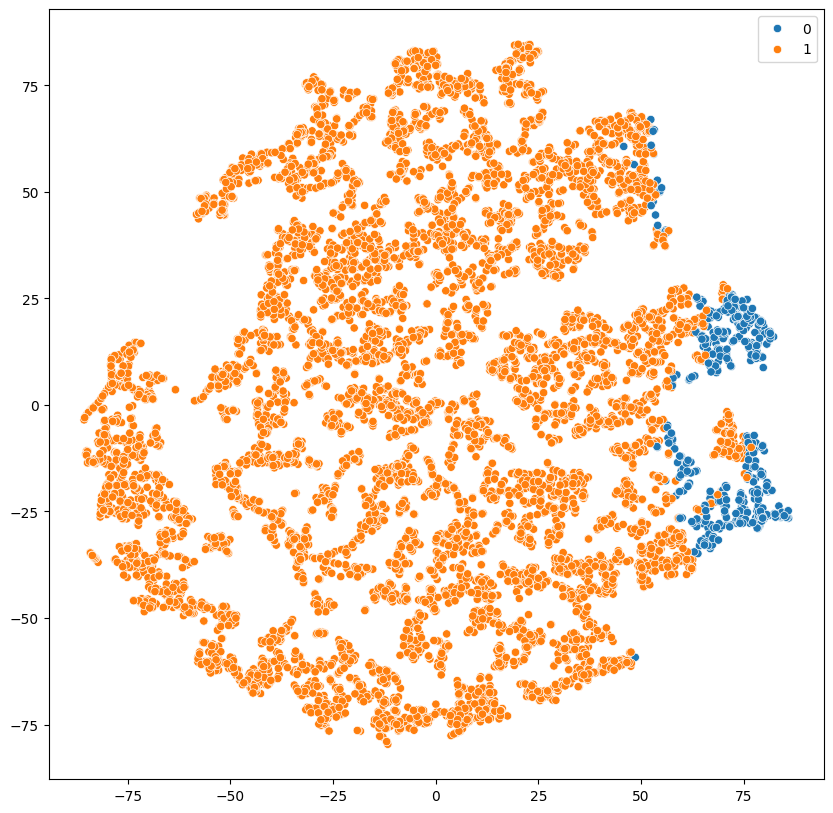

In [19]:
plot(tsne_data, kmeans_labels) # стало хуже, а если 4?

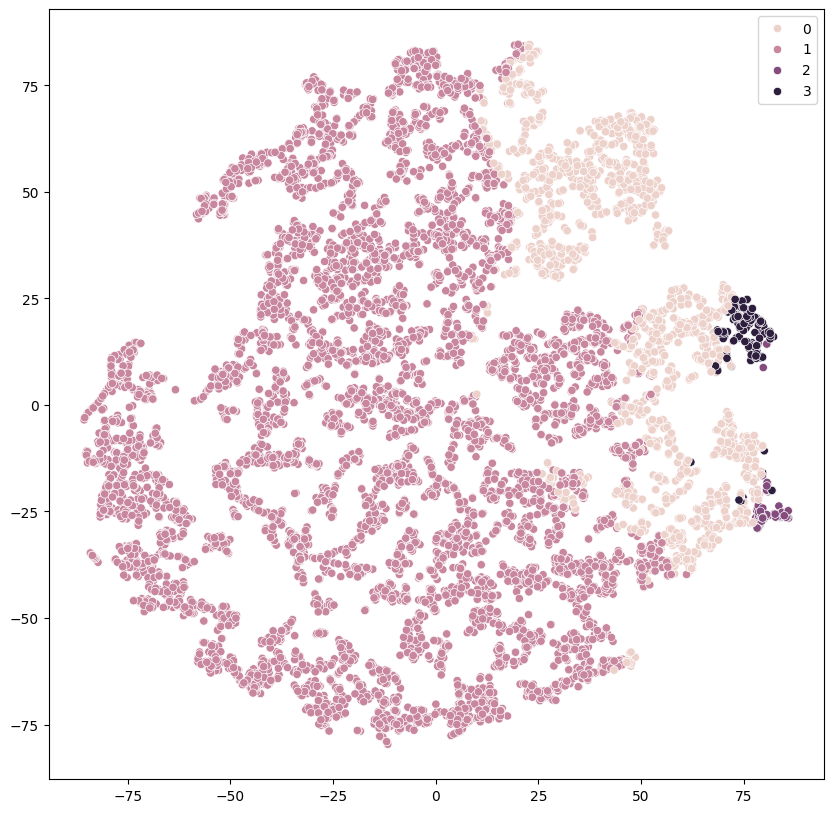

In [20]:
kmeans = KMeans(n_clusters=4, max_iter=500, tol=1e-3, random_state=42)
kmeans_labels = kmeans.fit_predict(df_numeric)
plot(tsne_data, kmeans_labels)

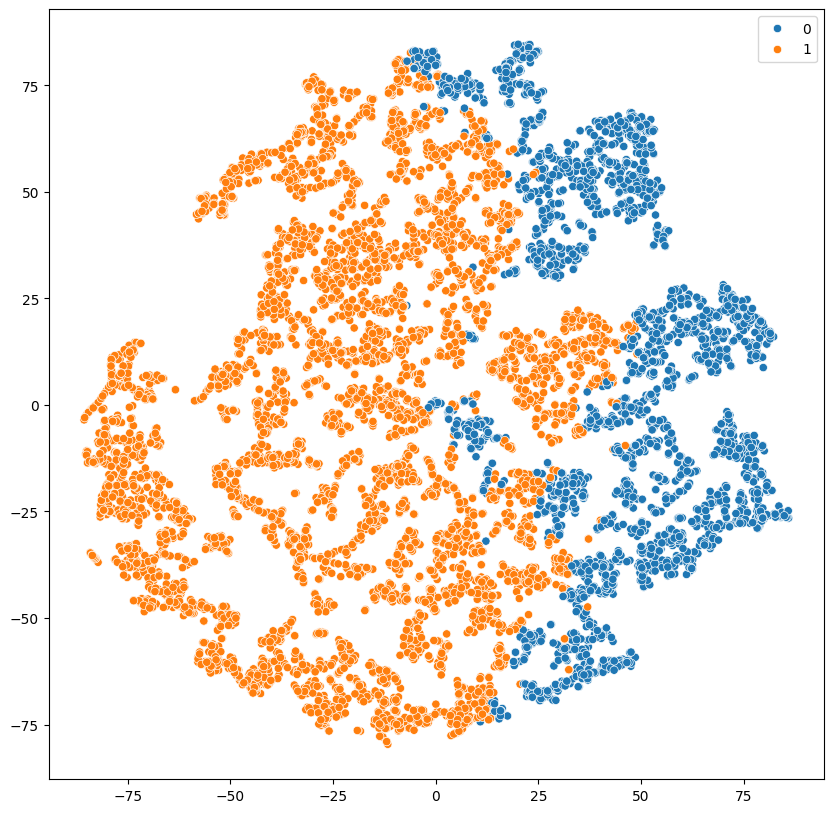

In [21]:
agg_result = AgglomerativeClustering(2).fit(df_numeric)
plot(tsne_data, agg_result.labels_) # ого, кажется, лучше предыдущих моделей

итого, более равномерно распределили на два класса с помощью AgglomerativeClustering

его явный плюс - детерменированность

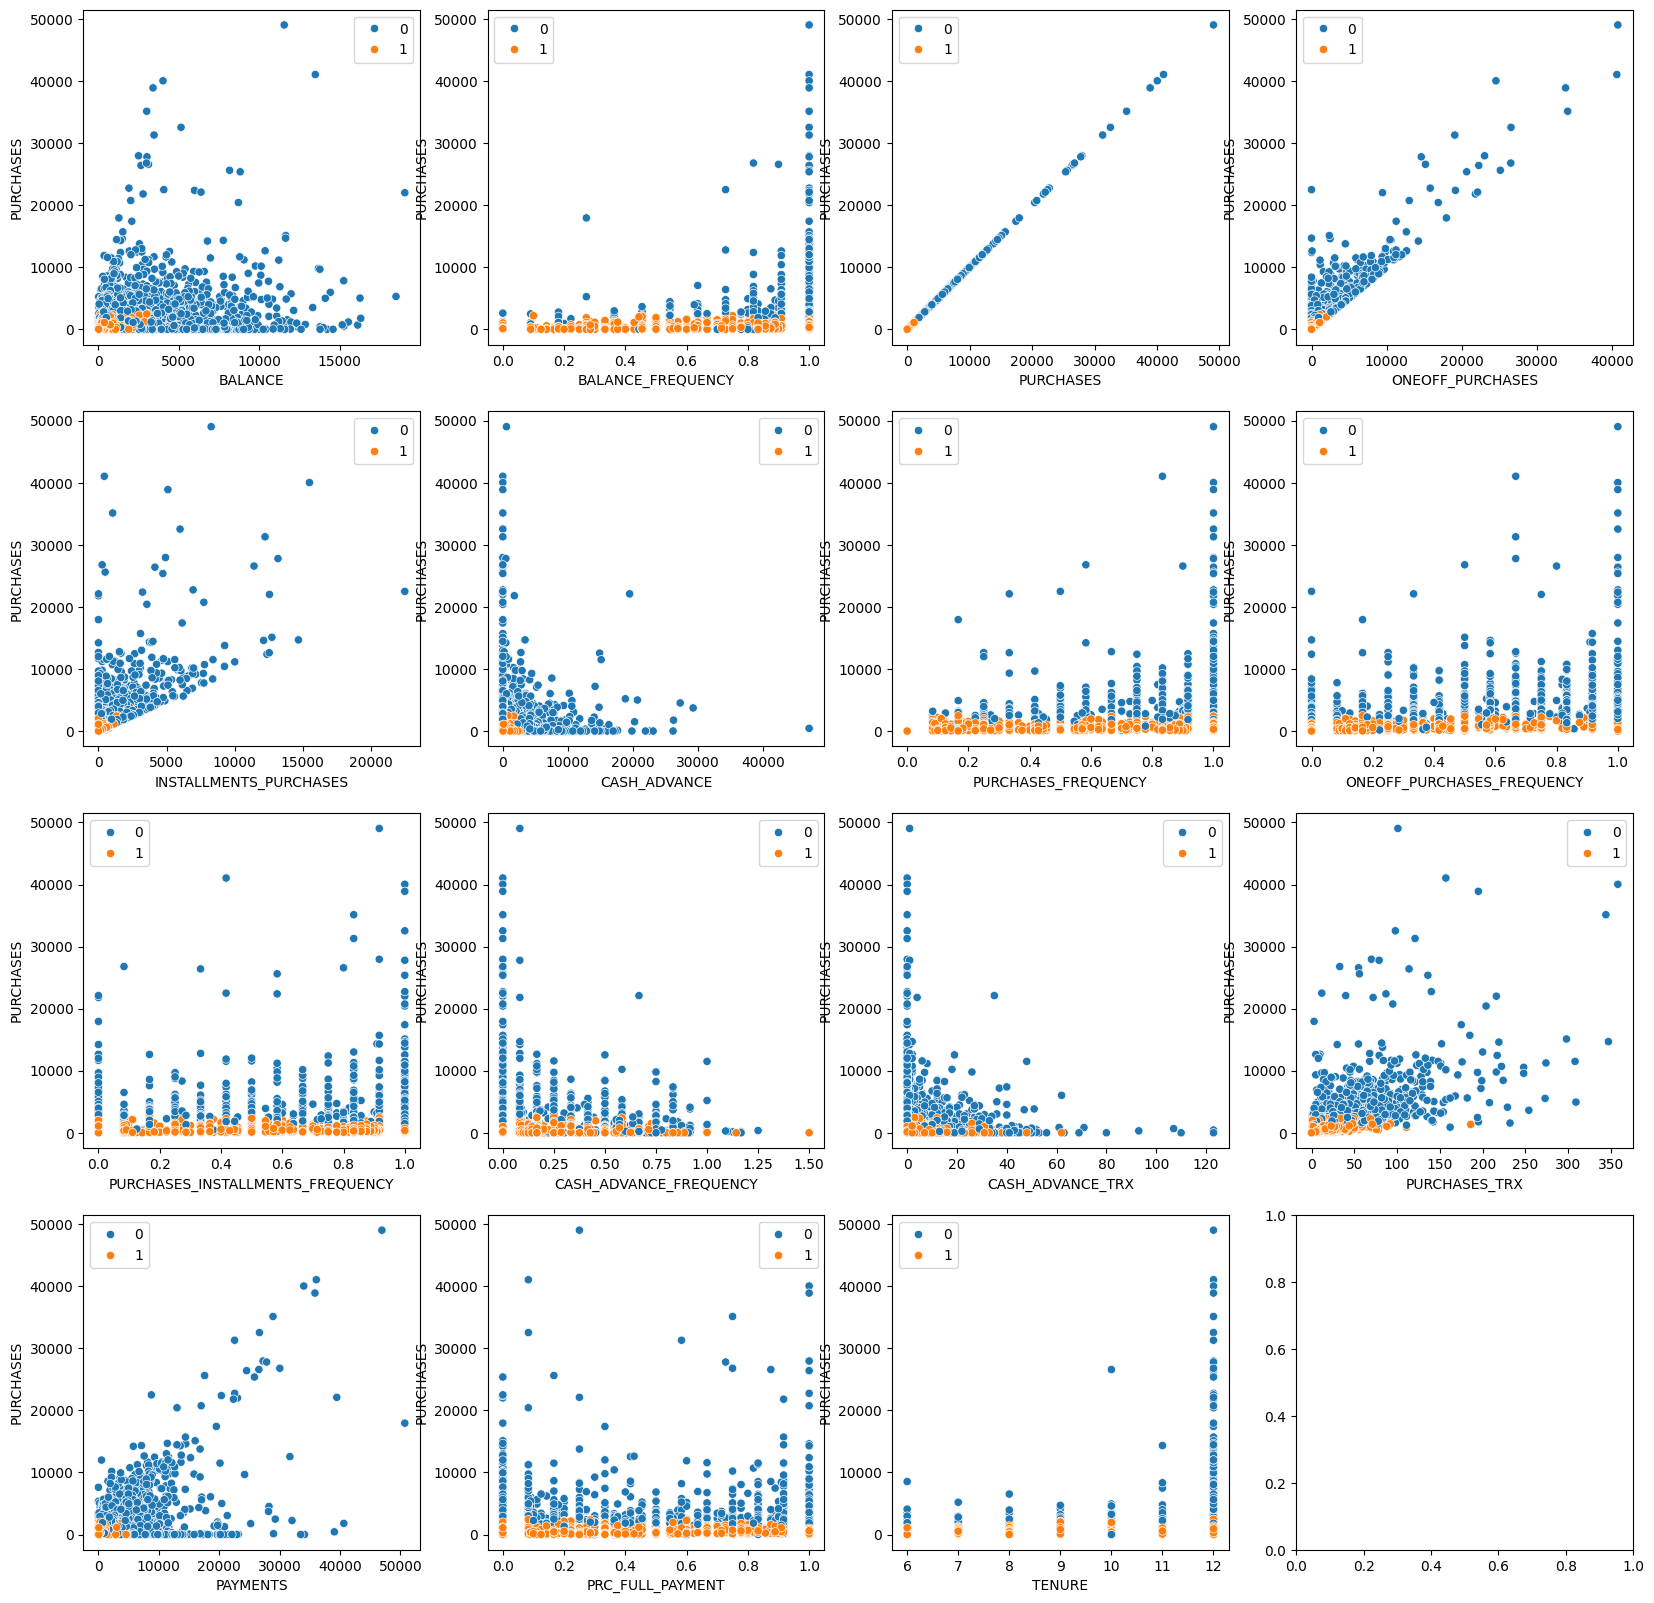

In [22]:
plt.subplots(nrows=4 , ncols=4, figsize=(20, 20))
j = 1
for col in df_numeric.columns:
    plt.subplot(4, 4, j)
    ax = sns.scatterplot(x=col , y='PURCHASES', hue=agg_result.labels_, data=df_numeric)
    j += 1


## Hard

Построить модель, которая будет предсказывать, насколько обеспеченный пользователь. Добавить в такую модель кластеризацию/метод понижения размерности и проверить, можно ли улучшить качество (или хотя бы не потерять), уменьшив при этом размер датасета?

Важно: в этой задаче нужно определить, что такое "обеспеченный пользователь" и не переобучиться (сделать так, чтобы в train и test были действительно разные данные, которые никак друг с другом не связаны)

In [23]:
# no:)